In [56]:
import weaviate
from weaviate.classes.config import Configure, Property, DataType, Multi2VecField
import base64
from PIL import Image
import io
import os
from tqdm import tqdm
import json


## Utility Functions

In [57]:
def read_image_data(image_path):
    """Read image as base64 and PIL object, caching to avoid redundant reads"""
    with open(image_path, "rb") as img_file:
        raw_data = img_file.read()
        base64_data = base64.b64encode(raw_data).decode("utf-8")
        pil_img = Image.open(io.BytesIO(raw_data))
    return base64_data, pil_img

def process_metadata(metadata, max_chars=200):
    """Process captions from metadata"""
    captions = metadata.get("captions", [])
    concatenated = " ".join(captions)[:max_chars] if captions else "No captions available"
    return concatenated

## Schema Creation

In [58]:
def create_flickr_schema_multi2vec(client, collection_name, image_weight=0.5):
    """Create schema for multi2vec-clip"""
    if client.collections.exists(collection_name):
        client.collections.delete(collection_name)
        print(f"existing {collection_name} deleted, creating a new one.")
    
    image_weight = round(image_weight, 2)
    text_weight = round(1.0 - image_weight, 2)

    client.collections.create(
        collection_name,
        properties=[
            Property(name="image", data_type=DataType.BLOB),
            Property(name="image_id", data_type=DataType.TEXT),
            Property(name="captions", data_type=DataType.TEXT),
        ],
        vectorizer_config=[
            Configure.NamedVectors.multi2vec_clip(
                name="image_vector",
                image_fields=[Multi2VecField(name="image", weight=image_weight)],
                text_fields=[Multi2VecField(name="captions", weight=text_weight)]
            )
        ]
    )
    print(f"Created {collection_name} schema")

## Import Data to Collection

In [59]:
def import_data_multi2vec(client, data_dir, collection_name, batch_size=100):
    """Import data with multi2vec-clip"""
    collection = client.collections.get(collection_name)
    images_dir = os.path.join(data_dir, "images")
    metadata_dir = os.path.join(data_dir, "metadata")
    metadata_files = [f for f in os.listdir(metadata_dir) if f.endswith('.json')]
    print(f"Importing {len(metadata_files)} images for multi2vec")

    batch_errors = []
    with collection.batch.fixed_size(batch_size=batch_size) as batch:
        for metadata_file in tqdm(metadata_files):
            try:
                with open(os.path.join(metadata_dir, metadata_file), 'r') as f:
                    metadata = json.load(f)
                
                image_path = os.path.join(images_dir, f"image_{metadata['image_id']}.jpg")
                image_data, _ = read_image_data(image_path)
                captions = process_metadata(metadata)
                
                batch.add_object(
                    properties={
                        "image": image_data,
                        "image_id": metadata["image_id"],
                        "captions": captions
                    }
                )
            except Exception as e:
                batch_errors.append(f"Error processing {metadata_file}: {str(e)}")
                continue
    if batch_errors:
        print(f"Encountered {len(batch_errors)} errors during batch import")
        for err in batch_errors[:5]:  # Print first 5 errors
            print(err)
    print("Finished multi2vec import")

In [60]:
# Connect to Weaviate
client = weaviate.connect_to_local()

data_dir = "/Users/roshanakzakizadeh/Projects/multimodal_comparison/flickr30k_sample"

create_flickr_schema_multi2vec(client, collection_name="Flickr30k_multi2vec", image_weight=0.5)

import_data_multi2vec(client, data_dir, collection_name="Flickr30k_multi2vec")

client.close ()

existing Flickr30k_multi2vec deleted, creating a new one.
Created Flickr30k_multi2vec schema
Importing 2569 images for multi2vec


/Users/roshanakzakizadeh/Projects/weaviate_multimodal_search/.venv/lib/python3.10/site-packages/weaviate/collections/classes/config.py:1963: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  for cls_field in self.model_fields:
/Users/roshanakzakizadeh/Projects/weaviate_multimodal_search/.venv/lib/python3.10/site-packages/weaviate/collections/classes/config_vectorizers.py:412: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  for cls_field in self.model_fields:
100%|██████████| 2569/2569 [08:13<00:00,  5.21it/s] 


Finished multi2vec import


## Query Search

In [61]:
import weaviate.classes as wvc
import time
from pathlib import Path

In [83]:
def query_text_search(collection_name: str, queries: list[str], k: int):
    """
    Runs query search inside the given collection
    Args:
        collection_name: name of the collection on Weaviate
        queries: list of words or phrases
        k : number of items to retrieve from the collection
    Returns:
        Dictionary containg search results with latency, image_ids, caption and similarities
    
    """
    client = weaviate.connect_to_local()
    collection = client.collections.get(collection_name)
    response = collection.aggregate.over_all(total_count=True)
    print(f"{collection_name} collection size is : {response.total_count}")

    results = {}

    for query in queries:
        try:
            start_time = time.time()
            response = collection.query.near_text(
                query=query,
                limit=k,
                return_metadata=wvc.query.MetadataQuery(distance=True)
            )        

            latency = time.time() - start_time

            similarities = [obj.metadata.distance for obj in response.objects]
            print(f"Query: {query}, Similarities: {similarities}")
            retrieved_ids = [obj.properties['image_id'] for obj in response.objects]
            retrieved_captions = [obj.properties['captions'] for obj in response.objects]

            results[query] = {
                "latency": latency,
                "image_ids": retrieved_ids,
                "captions": retrieved_captions,
                "similarities": similarities
            }
        except Exception as e:
            print(f"error processing query {query} in {collection_name}: {str(e)}")
            results[query] = {
                "latency": 0.0,
                "image_ids": [],
                "captions": [],
                "similarities": []
            }
    
    client.close()
    return results

def query_hybrid_search(collection_name: str, text_query: str, image_path: str, k: int, text_weight: float):
    """
    Combines text and image search in the given collection using multi2vec-clip
    
    Args:
        collection_name: name of the collection on Weaviate
        text_query: text to search for
        image_path: path to the query image
        k: number of items to retrieve
    
    Returns:
        Dictionary containing search results with latency, image_ids, captions, and similarities
    """
    client = weaviate.connect_to_local()
    collection = client.collections.get(collection_name)
    
    try:
        start_time = time.time()
        
        # First try text search
        text_response = collection.query.near_text(
            query=text_query,
            limit=k,
            return_metadata=wvc.query.MetadataQuery(distance=True)
        )
        
        # Then try image search
        image_response = collection.query.near_image(
            near_image=Path(image_path),
            limit=k,
            return_metadata=wvc.query.MetadataQuery(distance=True)
        )
        
        # Print raw distances before normalization
        print("\nRaw distances:")
        print("Text search distances:", [obj.metadata.distance for obj in text_response.objects])
        print("Image search distances:", [obj.metadata.distance for obj in image_response.objects])
   
         # Get max distances for normalization
        text_max = max(obj.metadata.distance for obj in text_response.objects)
        image_max = max(obj.metadata.distance for obj in image_response.objects)
        print("\nMax distances:")
        print(f"Text max: {text_max}")
        print(f"Image max: {image_max}")

        print("\nAfter normalization and weighting:")
          # Combine and rank results (simple averaging of distances)
        combined_results = {}
        for obj in text_response.objects:
            normalized_distance = (obj.metadata.distance / text_max) * (1.0 - text_weight)
            print(f"Text ID {obj.properties['image_id']}: {normalized_distance}")

            combined_results[obj.properties['image_id']] = {
                'distance': normalized_distance,
                'properties': obj.properties,
                'count': 1
            }
            
        for obj in image_response.objects:
            img_id = obj.properties['image_id']
            normalized_distance = (obj.metadata.distance / image_max) * text_weight
            print(f"Image ID {obj.properties['image_id']}: {normalized_distance}")

            if img_id in combined_results:
                combined_results[img_id]['distance'] += normalized_distance
                combined_results[img_id]['count'] = 2
            else:
                combined_results[img_id] = {
                    'distance': normalized_distance,
                    'properties': obj.properties,
                    'count': 1
                }
        
        # Sort by distance and count (prioritize items that appeared in both searches)
        sorted_results = sorted(
            combined_results.items(), 
            key=lambda x: x[1]['distance']
        )[:k]
        
        latency = time.time() - start_time
        
        # Process results
        retrieved_ids = [item[0] for item in sorted_results]
        retrieved_captions = [item[1]['properties']['captions'] for item in sorted_results]
        similarities = [item[1]['distance'] for item in sorted_results]

        # Print final combined distances
        print("\nFinal combined distances:")
        for item in sorted_results:
            print(f"ID: {item[0]}, Distance: {item[1]['distance']}")
        
        results = {
            text_query: {
                "latency": latency,
                "image_ids": retrieved_ids,
                "captions": retrieved_captions,
                "similarities": similarities
            }
        }
        
        return results
    
    except Exception as e:
        print(f"Error in hybrid search: {str(e)}")
        return {
            text_query: {
                "latency": 0.0,
                "image_ids": [],
                "captions": [],
                "similarities": []
            }
        }
    finally:
        client.close()



    
def query_by_image(collection_name: str, image_path: str, k: int):
    """
    Search using only image in the given collection
    
    Args:
        collection_name: name of the collection on Weaviate
        image_path: path to the query image
        k: number of items to retrieve
    
    Returns:
        Dictionary containing search results with latency, image_ids, captions, and similarities
    """
    client = weaviate.connect_to_local()
    collection = client.collections.get(collection_name)
    
    try:
        start_time = time.time()
        response = collection.query.near_image(
            near_image=Path(image_path),
            limit=k,
            return_metadata=wvc.query.MetadataQuery(distance=True)
        )
        
        latency = time.time() - start_time
        
        # Process results
        similarities = [obj.metadata.distance for obj in response.objects]
        retrieved_ids = [obj.properties['image_id'] for obj in response.objects]
        retrieved_captions = [obj.properties['captions'] for obj in response.objects]
        
        results = {
            "image_search": {
                "latency": latency,
                "image_ids": retrieved_ids,
                "captions": retrieved_captions,
                "similarities": similarities
            }
        }
        
        return results
    
    except Exception as e:
        print(f"Error in image search: {str(e)}")
        return {
            "image_search": {
                "latency": 0.0,
                "image_ids": [],
                "captions": [],
                "similarities": []
            }
        }
    finally:
        client.close()

## Results Visualization

In [63]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_search_results(results: dict, query: str, images_dir: str):
    """
    displays images along with their captions.
    """
    print(f"Images retrieved for the query {query}:")

    for img_id in results[query]['image_ids']:
        image_path = os.path.join(images_dir, "image_" + img_id + '.jpg')
        img = Image.open(image_path)
        plt.figure()
        plt.imshow(img)

        caption = results[query]['captions'][results[query]['image_ids'].index(img_id)]
        plt.title(f'Image ID {img_id}. Caption: {caption}', wrap=True)

        plt.axis('off')
        plt.show()

def visualize_search_results(results: dict, query: str, top_k: int = 3):
    """
    Create a grid visualization of results with metrics
    """
    fig, axes = plt.subplots(1, top_k, figsize=(15, 5))
    fig.suptitle(f'Results for query: "{query}"')
    
    for idx, (img_id, caption, distance) in enumerate(zip(
        results[query]['image_ids'][:top_k],
        results[query]['captions'][:top_k],
        results[query]['similarities'][:top_k]
    )):
        # Display image
        axes[idx].imshow(Image.open(f"{data_dir}/images/image_{img_id}.jpg"))
        axes[idx].set_title(f'Distance: {distance:.3f}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
def demo_search_types(query_text, query_image_path):
    collection_name = "Flickr30k_multi2vec"
        
    # Test image-only search
    image_results = query_by_image(
        collection_name=collection_name,
        image_path=query_image_path,
        k=3
    )
    
   

In [64]:
# query_text = "a dog playing in the park"
# query_image_path = "./weaviate_data/image_queries/dog-4362595_640.jpg"
# query_text = "Children in colorful raincoats splashing in puddles"
# query_image_path = "./weaviate_data/image_queries/child-504321_640.jpg"
query_text = "a close-up of hands creating traditional handicrafts"
query_image_path = "./weaviate_data/image_queries/clay-1139098_640.jpg"

In [65]:
# text search
# collection_name = "Flickr30k_multi2vec"
# results = query_text_search(collection_name=collection_name, queries=[query_text], k=3)
# visualize_search_results(results=results, query=query_text, top_k=3)

Flickr30k_multi2vec collection size is : 2569
Query: a close-up of hands creating traditional handicrafts, Similarities: [0.4566490650177002, 0.4720649719238281, 0.4756138324737549]
Images retrieved for the query a close-up of hands creating traditional handicrafts:


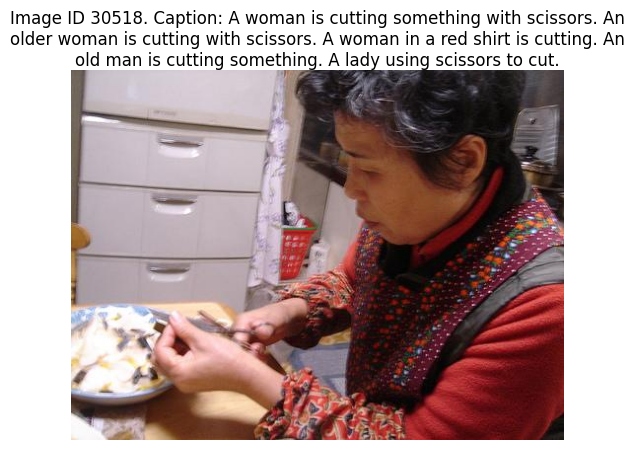

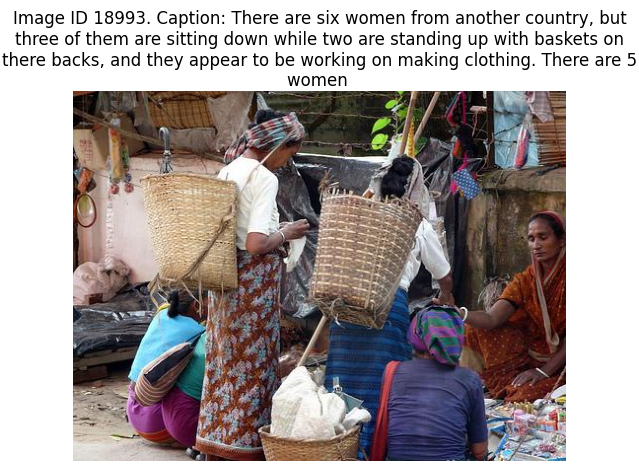

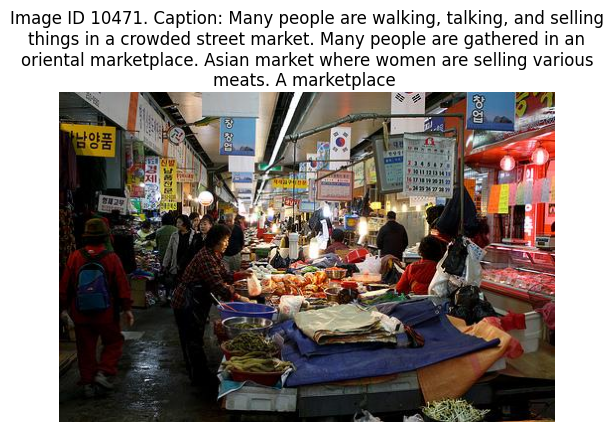

In [66]:
# to see the captions run display_search_results
# text search
collection_name = "Flickr30k_multi2vec"
results = query_text_search(collection_name=collection_name, queries=[query_text], k=3)
display_search_results(results=results, query=query_text, images_dir=data_dir+'/images')

Images retrieved for the query image_search:


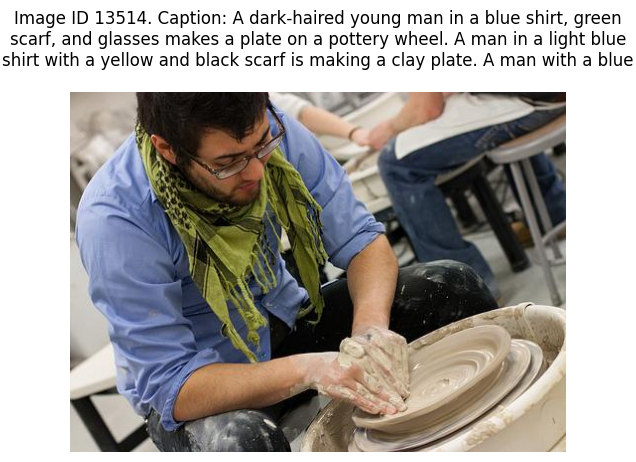

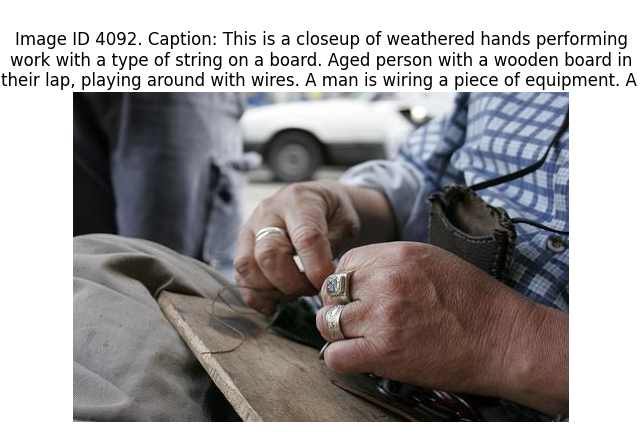

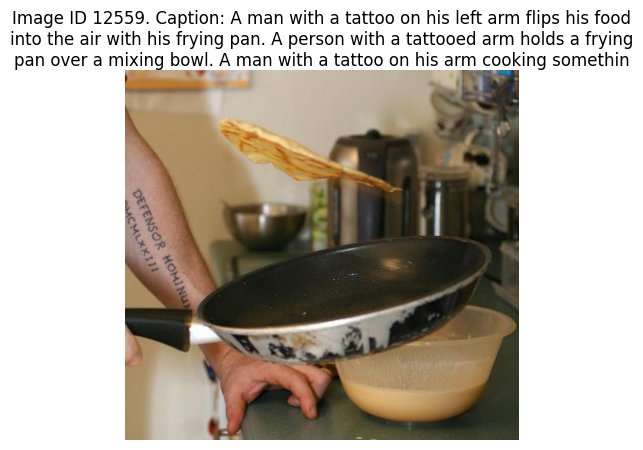

In [67]:
# image search
collection_name = "Flickr30k_multi2vec"
    
# Test image-only search
image_results = query_by_image(
    collection_name=collection_name,
    image_path=query_image_path,
    k=3
)

display_search_results(image_results, "image_search", images_dir=data_dir+'/images')



Raw distances:
Text search distances: [0.4566490650177002, 0.4720649719238281, 0.4756138324737549]
Image search distances: [0.3034632205963135, 0.35371387004852295, 0.3604837656021118]

Max distances:
Text max: 0.4756138324737549
Image max: 0.3604837656021118

After normalization and weighting:
Text ID 30518: 0.4800628512448687
Text ID 18993: 0.4962691785776409
Text ID 10471: 0.5
Image ID 13514: 0.42091107776995507
Image ID 4092: 0.4906099855255878
Image ID 12559: 0.5

Final combined distances:
ID: 13514, Distance: 0.42091107776995507
ID: 30518, Distance: 0.4800628512448687
ID: 4092, Distance: 0.4906099855255878
Images retrieved for the query a close-up of hands creating traditional handicrafts:


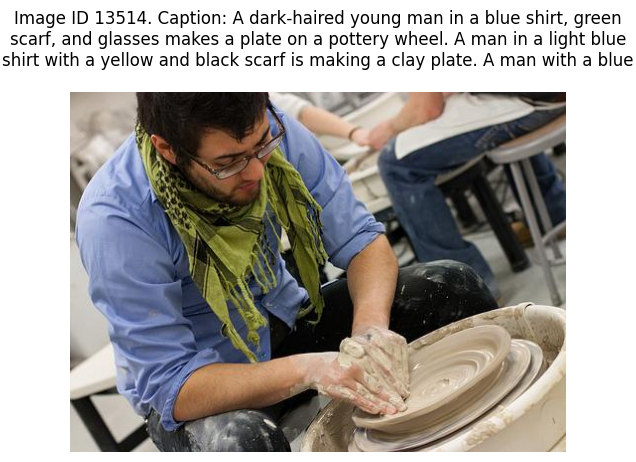

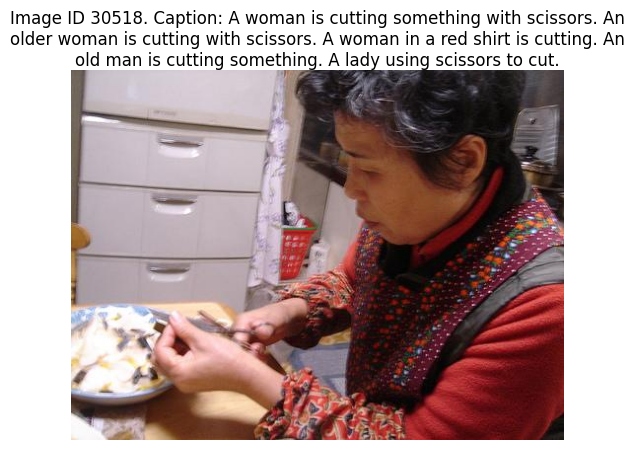

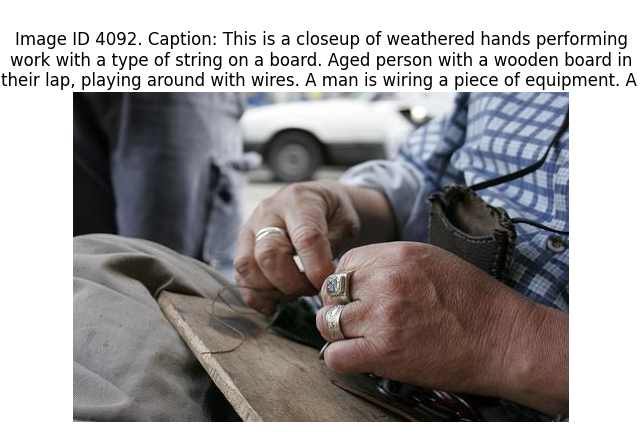

In [88]:
# hybrid search
# Test hybrid search
hybrid_results = query_hybrid_search(
    collection_name=collection_name,
    text_query=query_text,
    image_path=query_image_path,
    k=3,
    text_weight=0.5
)

# Display results using the visualization function you already have
display_search_results(hybrid_results, query_text , images_dir=data_dir+'/images')